# Kalman Filter Experiments 

Load the data.
In this experiment, I train 20 tasks sequentially.
The first dataset is the original Mnist data, the others are the permuted mnist dataset with different seed, so the images are differnet.

Assumes the datasets are D_1,D_2,D_3,D_4...D_20

After training on these datasets, I train the model on the first 3 dataset again, which are D1,D2 and D_3.

Summary:

    Advantages:
        1. The model can protect the D1 in a promising rate(the lowest accuracy is 0.8766)
        2. The model can learn the new task
        3. The model can learn the previous tasks again in a efficient rate
    Disadvantages:
        1. The model cannot learn the new tasks as well as the first one
        2. The capacity of learning new tasks is decreasing drmatically(0.34 on the 4th dataset)
        3. The model cannot learn the disjoint datasets. (For example,assumes task T have label 0 and 1, we split T into T_1 and T2, 
        where T1 contains the data with label 0, T2 contains data with label 1. The kalman model cannot learn T1 and T2 sequentially.)

In [91]:
#Load the drift data
TASK_NUM = 20
task = create_permuted_mnist_task(TASK_NUM)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


#### This is the training images

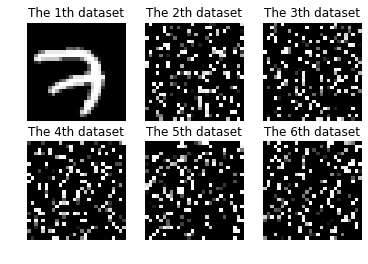

In [105]:
for i in range(6):
    plt.subplot(2,3,i+1)
    mnist_imshow(task[i].train.images[0])
    plt.title('The {}th dataset'.format(str(i+1)))

##### We train the kalman network first. 

Different from previous kalman filter, the fisher information is added into the Kalman Gain to cater the new tasks.
 $K_k = \frac{P_{k|k-1} } { (P_{k|k-1} + R * F^*) }$

The $F^*$ is the normalized Fisher Information. The reason is that the model will be strictly restricted from the previous gradients($P$)
which is relatively lower than the current gradient($R$). So I normalize the Fisher Information by using $F_i^* = \frac{F_i - \min F_i}{\max F_i - \min F_i}$

In this experiment, I use the emperical diagonal fisher information(The same as this [paper](https://arxiv.org/pdf/1612.00796.pdf)). It's calculated by squaring the gradients.

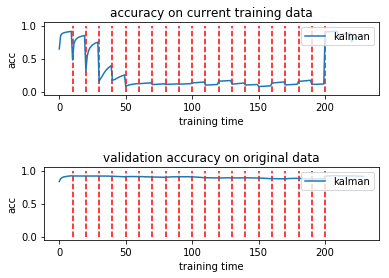

In [103]:
plot_history(kal_history,'res','kalman',shift=20)

The precise accuracy of the training data(The first figure) is: (Te last 3 is the go back training accuracy on the D1,D2 and D3 respectively).
###### The model can only learn the first 3 datasets in an acceptable rate. According to my other experiments, it cannot be fixed by simply adding layers. 

In [100]:
acc_kal = kal_history.history['acc'][::9][1:]
for acc in acc_kal:
    print(str(acc)[:5],end='  ')

0.913  0.846  0.733  0.342  0.218  0.107  0.122  0.107  0.108  0.111  0.120  0.142  0.104  0.163  0.122  0.102  0.079  0.132  0.101  0.153  0.170  0.114  0.913  0.881  0.835  

#### The precise accuracy of D1 (The second figure) is: (The last 3 is the go back training accuracy on the D1,D2 and D3 respectively). It shows that the model can learn the learnt dataset efficiently. 

In [96]:
print(kal_history.history['val_acc'][::9][1:])

[0.9212, 0.9184, 0.9196, 0.9172, 0.9104, 0.9102, 0.9086, 0.904, 0.9016, 0.9068, 0.9044, 0.8938, 0.889, 0.891, 0.8892, 0.8908, 0.8862, 0.8782, 0.8766, 0.8822, 0.8714, 0.8758, 0.9236, 0.9208, 0.9168]


##### Train a conventional neural networks

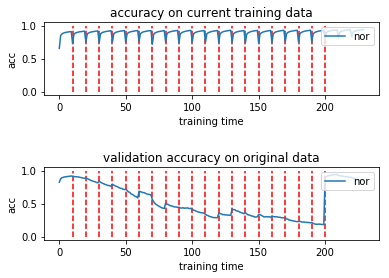

In [107]:
plot_history(nor_history,'res','nor',shift=20)

#### The precise accuracy of the training data(The first figure) is: (Te last 3 is the go back training accuracy on the D1,D2 and D3 respectively).

In [101]:
acc_nor = nor_history.history['acc'][::9][1:]
for acc in acc_nor:
    print(str(acc)[:5],end='  ')

0.910  0.914  0.914  0.914  0.913  0.908  0.903  0.888  0.876  0.740  0.928  0.922  0.919  0.921  0.912  0.908  0.901  0.895  0.879  0.753  0.930  0.926  0.932  0.933  0.929  

#### The precise accuracy of D1 (The second figure) is: (The last 3 is the go back training accuracy on the D1,D2 and D3 respectively).

In [102]:
print(nor_history.history['val_acc'][::9][1:])

[0.9188, 0.8882, 0.8304, 0.779, 0.7408, 0.6458, 0.6664, 0.5012, 0.4916, 0.4446, 0.427, 0.36, 0.2866, 0.3282, 0.3796, 0.3174, 0.309, 0.2992, 0.2672, 0.2288, 0.2084, 0.1818, 0.9392, 0.909, 0.8618]


#### The accuracy comparison between kalman and normal neural network on the D1,D2 and D3 test dataset.

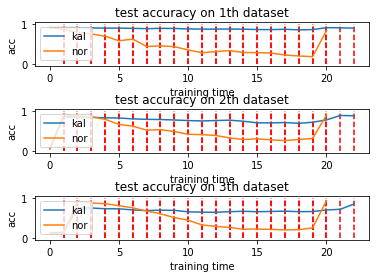

In [112]:
acc_plot('kal',kal_d1,1)
acc_plot('kal',kal_d2,2)
acc_plot('kal',kal_d3,3)
acc_plot('nor',nor_d1,1)
acc_plot('nor',nor_d2,2)
acc_plot('nor',nor_d3,3)

#### Precise accuracy

#### To make it clear, I calculate the $accuracy(kal) - accuracy(nor)$

In [124]:
import numpy as np
print('test accuracy differnt on D1:',(np.array(kal_d1[:21]) - np.array(nor_d1)))

accuracy diff: [0.0012 0.0469 0.1154 0.1553 0.2029 0.3198 0.2718 0.451  0.4424 0.4599
 0.5313 0.5983 0.5686 0.5469 0.5898 0.5841 0.5927 0.651  0.6611 0.6855
 0.0705]


In [126]:
import numpy as np
print('test accuracy differnt on D2:',(np.array(kal_d2[:21]) - np.array(nor_d2)))

test accuracy differnt on D2: [ 0.0022 -0.0603 -0.0209 -0.0103  0.0377  0.1631  0.1834  0.275   0.256
  0.2917  0.3463  0.3469  0.3769  0.4503  0.4605  0.4047  0.428   0.4575
  0.4093  0.4082 -0.1211]


In [127]:
import numpy as np
print('test accuracy differnt on D3:',(np.array(kal_d3[:21]) - np.array(nor_d3)))

test accuracy differnt on D3: [ 0.0109  0.0344 -0.1663 -0.1266 -0.1274 -0.0801 -0.052   0.0112  0.0914
  0.1831  0.2123  0.3241  0.3552  0.401   0.4548  0.4375  0.4534  0.4746
  0.4554  0.413  -0.2355]


#### Below is the precise test accuracy:

In [128]:
print('kalman model on D1:',kal_d1)
print('Conventional model on D1:',nor_d1)

kalman model on D1: [0.917, 0.9161, 0.916, 0.9104, 0.9031, 0.9043, 0.8981, 0.891, 0.8977, 0.8955, 0.8843, 0.879, 0.8786, 0.8821, 0.8774, 0.8678, 0.8664, 0.8745, 0.8606, 0.8673, 0.9158, 0.912, 0.9047]
Conventional model on D1: [0.9158, 0.8692, 0.8006, 0.7551, 0.7002, 0.5845, 0.6263, 0.44, 0.4553, 0.4356, 0.353, 0.2807, 0.31, 0.3352, 0.2876, 0.2837, 0.2737, 0.2235, 0.1995, 0.1818, 0.8453]


In [129]:
print('kalman model on D2:',kal_d2)
print('Conventional model on D2:',nor_d2)

kalman model on D2: [0.0543, 0.8611, 0.8592, 0.85, 0.8349, 0.8312, 0.8084, 0.797, 0.7926, 0.7805, 0.7662, 0.7565, 0.7662, 0.7761, 0.7487, 0.7081, 0.7063, 0.7159, 0.6966, 0.7229, 0.7828, 0.8946, 0.8878]
Conventional model on D2: [0.0521, 0.9214, 0.8801, 0.8603, 0.7972, 0.6681, 0.625, 0.522, 0.5366, 0.4888, 0.4199, 0.4096, 0.3893, 0.3258, 0.2882, 0.3034, 0.2783, 0.2584, 0.2873, 0.3147, 0.9039]


In [130]:
print('kalman model on D3:',kal_d3)
print('Conventional model on D3:',nor_d3)

kalman model on D3: [0.1187, 0.1425, 0.759, 0.7539, 0.736, 0.7335, 0.7055, 0.6886, 0.6999, 0.6954, 0.6577, 0.6497, 0.6463, 0.6614, 0.6711, 0.6607, 0.6672, 0.6744, 0.6613, 0.6649, 0.7037, 0.7225, 0.8561]
Conventional model on D3: [0.1078, 0.1081, 0.9253, 0.8805, 0.8634, 0.8136, 0.7575, 0.6774, 0.6085, 0.5123, 0.4454, 0.3256, 0.2911, 0.2604, 0.2163, 0.2232, 0.2138, 0.1998, 0.2059, 0.2519, 0.9392]
